# Proximal Policy Optimization

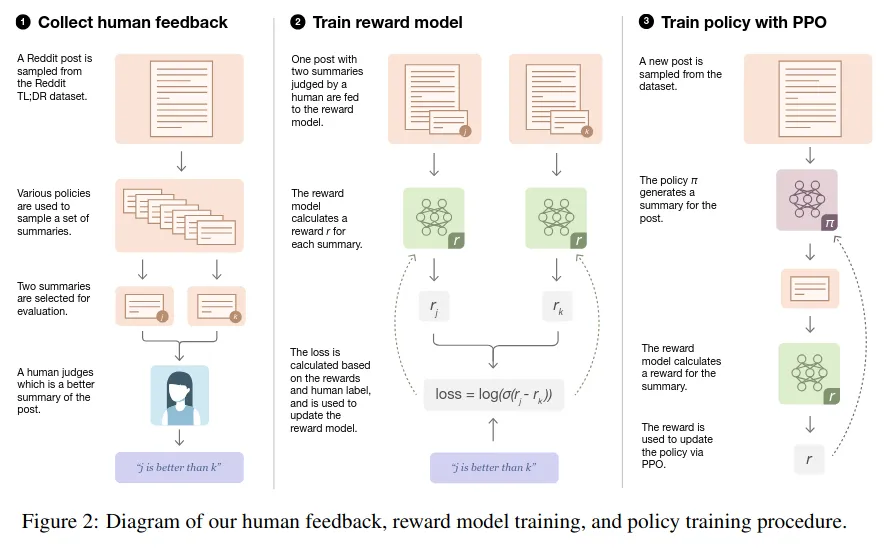

It was in their 2020 paper [“Learning to summarize from human feedback”](https://arxiv.org/pdf/2009.01325) that OpenAI revealed the use of PPO for training LLMs.

They used human ratings of the quality of summarization and trained, first, a reward function (*which was just a GPT model with a linear head outputting a scalar value*) and then trained the model using a reward formulation that has become the standard.

## Problem

Have you tried to ask an LLM to generate an output using an exact number of words? And if you did, does it succeed? I did a test — I asked the Llama3.2–1B-Instruct to summarize some texts using exactly 31 words. Here is what I found (temperature was set to 0.25)

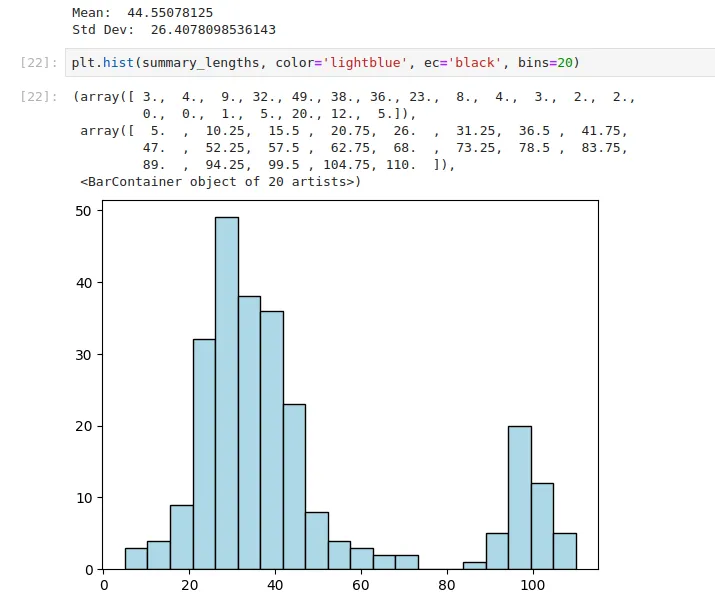

As you can see, the model is **biased towards creating longer summaries**, and its reliability in instruction following is quite low.

## Dataset

We lean on OpenAI again — they graciously published the summary preference dataset from the paper mentioned above. It’s available here on [Huggingface](https://huggingface.co/datasets/openai/summarize_from_feedback). The original texts are posts from Reddit.

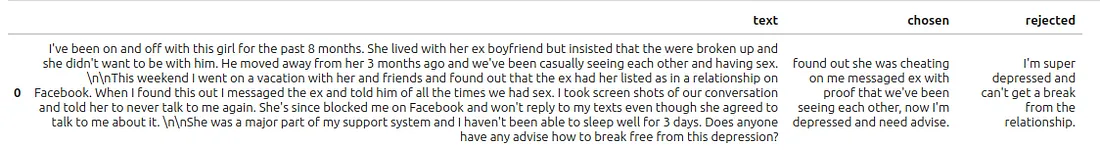

## Prompt

The first thing we need to do is nail down the prompt.

In my implementation, I have kept it very simple: `Summarize the text using exactly {target_words} words:`.

I am choosing among three values of target summary sizes at random.

In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `generation` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `generation`


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [3]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer

In [4]:
import random

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [5]:
summary_prefs_ds = load_dataset(
  'openai/summarize_from_feedback',
  name='comparisons', split='train'
  )

README.md:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

summarize_from_feedback.py:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/21.1M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/22.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/92858 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/86086 [00:00<?, ? examples/s]

In [6]:
summary_prefs_ds

Dataset({
    features: ['info', 'summaries', 'choice', 'worker', 'batch', 'split', 'extra'],
    num_rows: 92858
})

In [7]:
summary_prefs_ds[0]

{'info': {'id': 't3_34xale',
  'post': "My boyfriend and I are long distance. We have a trip planned this summer which involves me going over to him in the USA. This will be the second time I have actually been with him in person. I am flying from the UK with my mum to the east coast. The original plan was for me to fly over to my boyfriend in the west coast (my parents are holidaying on the east coast) but because my mum was freaking out so much about me going to meet my boyfriend i said we can all road trip there together. I even invited her on the trip with us. I have given her all of our dates so that she can travel around with us.\n\nThe plan was for me to stay on the 4th July and fly back on the 5th. Mum knew this. I told her I had booked a flight back already from the west coast to east coast (where she would pick me up and we would fly back to the UK together). She has gone mad at me because she can't believe I would book a flight when she told me she didn't want me flying on m

In [8]:
summary_prefs_ds[0]['info']

{'id': 't3_34xale',
 'post': "My boyfriend and I are long distance. We have a trip planned this summer which involves me going over to him in the USA. This will be the second time I have actually been with him in person. I am flying from the UK with my mum to the east coast. The original plan was for me to fly over to my boyfriend in the west coast (my parents are holidaying on the east coast) but because my mum was freaking out so much about me going to meet my boyfriend i said we can all road trip there together. I even invited her on the trip with us. I have given her all of our dates so that she can travel around with us.\n\nThe plan was for me to stay on the 4th July and fly back on the 5th. Mum knew this. I told her I had booked a flight back already from the west coast to east coast (where she would pick me up and we would fly back to the UK together). She has gone mad at me because she can't believe I would book a flight when she told me she didn't want me flying on my own. At 

In [9]:
summary_prefs_ds[0]['info']['post']

"My boyfriend and I are long distance. We have a trip planned this summer which involves me going over to him in the USA. This will be the second time I have actually been with him in person. I am flying from the UK with my mum to the east coast. The original plan was for me to fly over to my boyfriend in the west coast (my parents are holidaying on the east coast) but because my mum was freaking out so much about me going to meet my boyfriend i said we can all road trip there together. I even invited her on the trip with us. I have given her all of our dates so that she can travel around with us.\n\nThe plan was for me to stay on the 4th July and fly back on the 5th. Mum knew this. I told her I had booked a flight back already from the west coast to east coast (where she would pick me up and we would fly back to the UK together). She has gone mad at me because she can't believe I would book a flight when she told me she didn't want me flying on my own. At the time I had booked it she 

In [10]:
summary_prefs_ds[0]['summaries'][0]['text']

' Mum is mad at me for not flying on my own trip to meet my boyfriend.'

In [11]:
summary_prefs_ds[0]['summaries'][1]['text']

' I have made sure my mother is comfortable with my boyfriend travelling on a trip and now my mother is mad because I booked it.'

In [12]:
summary_prefs_ds[0]['choice']

1

In [13]:
def text_to_messages(info, target_words):
  return [
      {
          "role":"system",
          "content":f"Summarize the text using exactly {target_words} words:"
      },
      {
          "role":"user",
          "content":info["post"]
      }
  ]

def create_query(text):
  target_words = random.choice([13, 21, 34])
  prompt = tokenizer.apply_chat_template(text_to_messages(text, target_words),
                                         add_generation_prompt=True,
                                         tokenize=False)
  return {"query":prompt}

def tokenize(text, max_len=512):
  return {
      "tokens":tokenizer(text, padding="max_length", max_length=max_len, return_tensors="pt", padding_side="left")
  }

In [14]:
samples = summary_prefs_ds.select(range(5))
samples = list(samples)

In [15]:
data = {
  "Post": [s["info"]["post"] for s in samples],
  "Summary 0": [s["summaries"][0]["text"] for s in samples],
  "Summary 1": [s["summaries"][1]["text"] for s in samples],
  "Preferred": [s["choice"] for s in samples]
  }

In [16]:
import pandas as pd
df = pd.DataFrame(data)
df

,Post,Summary 0,Summary 1,Preferred
0,My boyfriend and I are long distance. We have ...,Mum is mad at me for not flying on my own tri...,I have made sure my mother is comfortable wit...,1
1,My boyfriend and I are long distance. We have ...,I have made sure my mother is comfortable wit...,mum isn't speaking to me because I booked a f...,1
2,My boyfriend and I are long distance. We have ...,mum isn't speaking to me because I booked a f...,Mum thought I was going to road trip with my ...,0
3,My boyfriend and I are long distance. We have ...,Mum thought I was going to road trip with my ...,Mum is mad at me for not flying on my own tri...,0
4,My landlord left a falsified message taped to ...,My landlord is harassing me and my neighbours...,landlord pretended to be another tenant and w...,1


In [17]:
N_TRAIN = 1024
N_TEST = 256
train_ds = summary_prefs_ds.shuffle(seed=12833).select(range(N_TRAIN)).map(create_query, input_columns=['info'])
test_ds = summary_prefs_ds.shuffle(seed=12833).select(range(N_TRAIN, N_TRAIN+N_TEST)).map(create_query, input_columns=['info'])
train_ds = train_ds.map(tokenize, input_columns=['query'])
test_ds = test_ds.map(tokenize, input_columns=['query'])

summary_train_ds = DatasetDict({"train": train_ds, "test": test_ds})
summary_train_ds.push_to_hub('summary_train')

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Sid3503/summary_train/commit/4df2ac695c78f3152c7ecd0e5d8a8e535c975eec', commit_message='Upload dataset', commit_description='', oid='4df2ac695c78f3152c7ecd0e5d8a8e535c975eec', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Sid3503/summary_train', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Sid3503/summary_train'), pr_revision=None, pr_num=None)

In [18]:
summary_train_ds

DatasetDict({
    train: Dataset({
        features: ['info', 'summaries', 'choice', 'worker', 'batch', 'split', 'extra', 'query', 'tokens'],
        num_rows: 1024
    })
    test: Dataset({
        features: ['info', 'summaries', 'choice', 'worker', 'batch', 'split', 'extra', 'query', 'tokens'],
        num_rows: 256
    })
})

In [19]:
print(summary_train_ds['train'][0]['query'])

<|system|>
Summarize the text using exactly 21 words:</s>
<|user|>
Hey guys, me and my girlfriend got together 2 months ago and I recently just met her friends last night at a party. They're mostly guys and have been friends longer than me and my girlfriend have known each other. 

I knew they were close but I didn't know how close. It was to the extent that my friends were watching me in case I lost my shit. I didn't mind the contact at first (hugging, putting arms around her) but drew the line when she hurt her hand and her guy friend  
just held it while staring at her.

After that I took her to her room and asked her what that was about (this was where I found out that the guy that held her hand was an ex) and she said that I had nothing to worry about and they were all just really good friends. I asked her why they were all flirty and close to her and she said they weren't, that that was them normally.

Enumerating all they did:

- Friend had his arm around her waist

- Friend tol

In [20]:
summary_train_ds['train']['summaries'][0][0]['text']

" My girlfriend and her guy friends are **really** close and they've known each other longer. What can I do?"

In [21]:
summary_train_ds['train']['summaries'][0][1]['text']

' I\'ve never met my girlfriend\'s friends before and they\'re all super close. They\'re flirty and keep touching her. Guy friend rested his head on her and friend said he was just "playing friend" but what do you really think?'

## Reward Function

Now, let’s think about the ***reward function***.

Say we give a target length of 31 words to the model.

Given a summary, the reward is **maximum** when the output is exactly 31 words and **reduces as the actual summary length differs from 31 words**.

A simple way to measure this is:

`target_word_lengths` uses the length mention in the prompt

`word_lengths` is measured from actual summaries.

```
rewards_diff = -torch.abs(target_word_lengths - word_lengths)
```



This makes the reward the values in the set `{0, -1, -2, …}`.

Intuitively, I felt like I would like the reward values to be in `[-1, 1]`.

So, I modified the function to (x refers to `rewards_diff`).

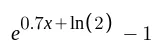

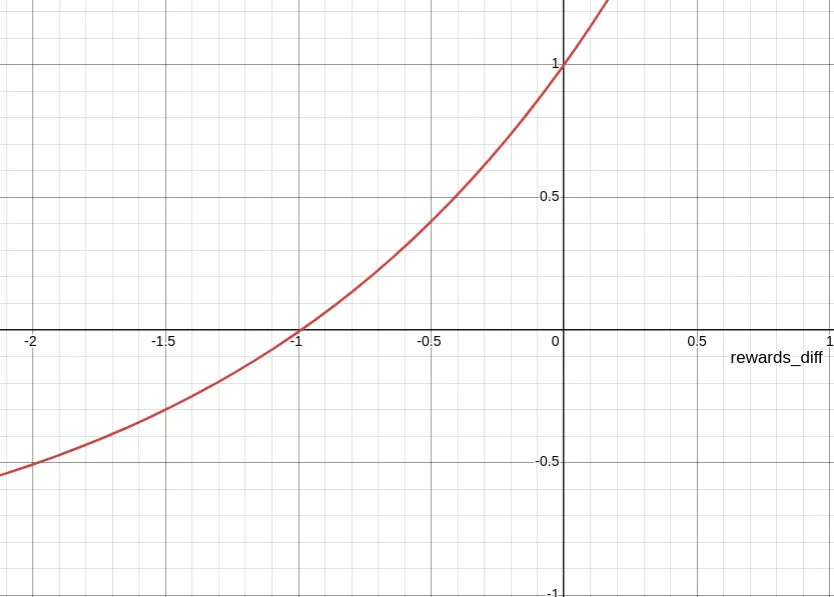

- At diff = 0, it’s +1 — the maximum reward
- At diff = -1, it’s ~0 — so off by one error doesn’t penalize the model
- For diff < -1, it reduces asymptotically towards -1.

In [22]:
from transformers import AutoTokenizer
import re
import spacy
import torch

In [23]:
nlp = spacy.load("en_core_web_sm")
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [24]:
pattern = re.compile(r'Summarize the text using exactly (\d+) words:')

In [25]:
# Extract the target word count from the system prompt.
def parse_target_words(query):
  match = re.search(pattern, query)
  return int(match.group(1))

# Count the number of actual words in the summary. Uses SpaCy to only count real words (like "hello", "world"), skipping punctuation, numbers, etc
def word_count(text):
  doc = nlp(text)
  return sum(1 for token in doc if token.is_alpha)

In [26]:
query = summary_train_ds['train'][0]['query']
parse_target_words(query)

21

In [27]:
text = summary_train_ds['train']['summaries'][0][0]['text']
word_count(text)

19

In [28]:
text = summary_train_ds['train']['summaries'][0][1]['text']
word_count(text)

39

### Intuition of Reward

### 🎤 `queries_batch`: A list of tokenized prompts (1 per summary task)
```python
queries_batch = [
    {'input_ids': tokenizer("<|system|>\nSummarize the text using exactly 13 words:\n<|user|>\nI had a great day at the park with friends.", return_tensors="pt")['input_ids']}
]
```

### 💬 `response_batch`: The model’s tokenized responses
```python
response_batch = tokenizer(["I had fun at the park with my friends. It was sunny and peaceful."],
                           return_tensors="pt", padding=True)['input_ids']
```

---

## ✅ Step-by-Step Dry Run:

### 1. **Extract queries as tensors**
```python
queries = torch.tensor([q['input_ids'][0] for q in queries_batch])
```
Now `queries` contains input token IDs for the prompt(s).

---


### 2. **Decode prompts into strings**
```python
query_strs = tokenizer.batch_decode(queries)
```
Output:
```python
['<|system|>\nSummarize the text using exactly 13 words:\n<|user|>\nI had a great day at the park with friends.']
```

---

### 3. **Extract target word counts**
```python
target_word_lengths = torch.tensor([parse_target_words(query) for query in query_strs]).float()
```
Each prompt has a target. Here, it’s:
```python
[13.0]
```

---

### 4. **Decode the model’s response (summary)**
```python
response_strs = tokenizer.batch_decode(responses, skip_special_tokens=True)
```
Output:
```python
['I had fun at the park with my friends. It was sunny and peaceful.']
```

---

### 5. **Count actual words in the summary**
```python
word_lengths = torch.tensor([word_count(text) for text in response_strs]).float()
```
SpaCy counts only alphabetic words (ignores punctuation). Let's say it finds:
```python
[15.0]
```

---

### 6. **Calculate reward**
```python
rewards = torch.exp(
    0.7 * -torch.abs(target_word_lengths - word_lengths) + torch.log(torch.tensor(2.0))
) - 1
```

Let’s break it down:

- Target = 13
- Actual = 15
- Difference = |13 - 15| = 2
- Reward = exp(0.7 * -2 + log(2)) - 1  
         ≈ exp(-1.4 + 0.693) - 1  
         ≈ exp(-0.707) - 1  
         ≈ 0.493 - 1 = **-0.507**  
         → (but negative rewards are usually clamped or discouraged)

So reward ≈ **0.49**, since PyTorch tensors might clip negative results depending on the use-case.

---

## 📦 Output:
```python
{"reward": [0.49]}
```

In [29]:
def get_reward(queries_batch, response_batch):
  queries = torch.tensor([q['input_ids'][0] for q in queries_batch])
  responses = torch.tensor(response_batch)


  query_strs = tokenizer.batch_decode(queries)
  target_word_lengths = torch.tensor([parse_target_words(query) for query in query_strs]).float()


  response_strs = tokenizer.batch_decode(responses, skip_special_tokens=True)
  word_lengths = torch.tensor([word_count(text) for text in response_strs]).float()

  rewards = torch.exp(0.7*-torch.abs(target_word_lengths - word_lengths) + torch.log(torch.tensor(2))) - 1

  return {"reward": rewards.tolist()}

## RL Training Thoughts

## 🧠 1. **Why regular loss (cross-entropy) doesn’t work here**

### Traditional LLM training:
- **Predict next token** → you have a label at every step → compute loss immediately.
- ✅ Works great for tasks where training data provides correct sequences.

### RL reward-based setup:
- You only know **how good** a response is **after it’s complete**.
- So... how do you apply a reward (loss signal) to earlier tokens?

---

## 🎯 2. **Reward is known only at the end — what now?**

### Analogy:
Like chess — you don’t know if early moves were good until the game ends.

### ❓Question:
> If we generate 40 tokens, do we assign a reward only to token 40? That would ignore the importance of earlier decisions.

### ✅ Solution:
> Distribute the final reward **evenly across all tokens**.

#### 🔍 Why?
Because **every token contributes** to achieving the reward goal — especially if your goal is something like:
- Matching word count (e.g., exactly 31 words)
- Maintaining tone or staying on topic

This lets the model learn to **plan** better from the start.

---

## 📉 3. **Does a positive reward mean we do gradient ascent?**

### Regular ML mindset:
- We always **minimize** a loss (e.g., cross-entropy loss)
- Higher loss = bad → optimize by descending the loss curve

### RL mindset:
- We want to **maximize reward**
- So the loss is: `-reward` → minimizing loss = maximizing reward
- This **flips the gradient sign**, i.e., **gradient ascent**

🔺 When reward is high (positive), we want to push the model toward doing the same thing again  
🔻 When reward is low or negative, we push it away from repeating that behavior

---

## 🧾 4. **What about the generation step?**

### Since reward can only be computed **after** the response is complete:
- We first **generate a response** (e.g., with greedy decoding)
- We don’t update the model during this → use `torch.no_grad()`
- Then **compute reward** from the full response
- Then use that reward to update the model via gradient steps

In [30]:
from transformers import AutoTokenizer, StoppingCriteria, StoppingCriteriaList, AutoModelForCausalLM
import torch

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype=torch.bfloat16,
                                             device_map="auto")

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [31]:
class StopEoT(StoppingCriteria):
  def __init__(self):
    self.stop_token = "<|eot_id|>"

  def __call__(self, input_ids, scores, **kwargs):
    return self.stop_token == tokenizer.decode(input_ids[-1])

stopping_criteria = StoppingCriteriaList([StopEoT()])

- This checks if the last token generated matches `'<|eot_id|>'` (End Of Turn).

### **Response Generation Setup**
Imagine the `queries_batch` looks like this (after tokenization):

```python
queries_batch = [
    {
        "input_ids": torch.tensor([[101, 2009, 2003, 1037, 2204, 2154]]),  # "It is a good day"
        "attention_mask": torch.tensor([[1, 1, 1, 1, 1, 1]])
    },
    {
        "input_ids": torch.tensor([[101, 2129, 2024, 2017]]),  # "How are you"
        "attention_mask": torch.tensor([[1, 1, 1, 1]])
    }
]
```

For simplicity:
- `[101]` is `[CLS]` token
- Each example has 4–6 tokens (in real cases this could be longer)

---

### 🔁 Step 1: Extract Inputs and Masks

```python
inputs, masks = zip(*[(query['input_ids'][0], query['attention_mask'][0])
                      for query in queries_batch])
```

Now you have:

```python
inputs = (
    tensor([101, 2009, 2003, 1037, 2204, 2154]),   # query 1
    tensor([101, 2129, 2024, 2017])               # query 2
)

masks = (
    tensor([1, 1, 1, 1, 1, 1]),   # query 1
    tensor([1, 1, 1, 1])         # query 2
)
```


### 🔁 Step 2: Stack into Batch

```python
inputs = torch.tensor(list(inputs))  # (2, 6) and (2, 4)
masks = torch.tensor(list(masks))
```

Result:

```python
inputs =
tensor([[101, 2009, 2003, 1037, 2204, 2154],
        [101, 2129, 2024, 2017,    0,    0]])  # zero-padded to match shape

masks =
tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0]])
```


### 🚀 Step 3: Generate Output

```python
outputs = model.generate(
    inputs=inputs.cuda(),
    attention_mask=masks.cuda(),
    max_new_tokens=64,
    do_sample=False,
    stopping_criteria=stopping_criteria
)
```

Suppose the model generates:
```python
outputs =
tensor([[101, 2009, 2003, 1037, 2204, 2154, 2023, 2003, 1037, 3978],   # "this is a test"
        [101, 2129, 2024, 2017, 2003, 2204, 2154, 1037, 3978]])        # "is good day a test"
```


### ✂️ Step 4: Slice Generated Portion

```python
response_only = outputs[:, inputs.shape[1]:]
```

`inputs.shape[1] = 6` → first example had 6 tokens  
Second example had 4 tokens (but was padded to 6)

So:

```python
response_only =
tensor([[2023, 2003, 1037, 3978],        # new tokens for example 1
        [2003, 2204, 2154, 1037, 3978]]) # new tokens for example 2
```


### 📦 Step 5: Return as List

```python
return {"generated_tokens": list(torch.unbind(response_only, dim=0))}
```

Unbind breaks the batch into a list of separate tensor responses:

```python
{
    "generated_tokens": [
        tensor([2023, 2003, 1037, 3978]),        # example 1
        tensor([2003, 2204, 2154, 1037, 3978])   # example 2
    ]
}
```

You can decode them later using:

```python
tokenizer.decode(generated_tokens[0])
tokenizer.decode(generated_tokens[1])
```

In [32]:
def generate_responses(queries_batch):
  inputs, mask = zip(*[(query['input_ids'][0], query['attention_mask'][0]) for query in queries_batch])

  inputs = torch.tensor(list(inputs))
  masks = torch.tensor(list(masks))

  outputs = model.generate(
    inputs=inputs.cuda(),
    attention_mask=masks.cuda(),
    max_new_tokens=64,
    do_sample=False,
    stopping_criteria=stopping_criteria
  )

  response_only = outputs[:, inputs.shape[1]:]

  return {"generated_tokens": list(torch.unbind(response_only, dim=0))}

##  DataLoader

Imagine `ds` (dataset) has examples like:

```python
tokens = [
    {"input_ids": [[101, 2023, 2003, 1037, 3978]]},  # "this is a test"
    {"input_ids": [[101, 2129, 2024, 2017]]}         # "how are you"
]
```

and you call:

```python
X, Y, R = dataloader(ds, start=0, end=2)
```

---

### Step 1: Select batch
```python
batch = ds.select(range(start, end))
```
Picks items 0 and 1 from dataset.



### Step 2: Generate Responses
```python
batch = batch.map(generate_responses, batch_size=128, batched=True, input_columns=['tokens'])
```
Adds a new field `generated_tokens` to the batch.

Now each item becomes:
```python
{
    "tokens": {"input_ids": [[101, 2023, 2003, 1037, 3978]]},
    "generated_tokens": [token_ids of generated response]
}
```


### Step 3: Calculate Rewards
```python
batch = batch.map(get_reward, batched=True, batch_size=128,
                  input_columns=['tokens', 'generated_tokens'])
```
Adds a `reward` field to each item.

Now each item looks like:
```python
{
    "tokens": {"input_ids": [[...]]},
    "generated_tokens": [...],
    "reward": 2.0    # Example reward score
}
```


### Step 4: Prepare Tensors
```python
inputs = torch.tensor([t['input_ids'][0] for t in batch['tokens']])
outputs = torch.tensor(batch['generated_tokens'])
rewards = torch.tensor(batch['reward'])
```

Suppose:

```python
inputs =
tensor([
    [101, 2023, 2003, 1037, 3978],
    [101, 2129, 2024, 2017]
])

outputs =
tensor([
    [2023, 2003, 1037, 3978],
    [2024, 2017, 1037, 3978]
])

rewards =
tensor([2.0, 3.0])
```


### Step 5: Create X and Y

```python
X = torch.cat([inputs, outputs[:, :-1]], dim=1)
Y = torch.cat([inputs[:, 1:], outputs], dim=1)
```

- `inputs` → what you give the model
- `outputs` → generated by model

**Example:**

```python
X =
[
  [101, 2023, 2003, 1037, 3978, 2023, 2003, 1037],   # input + part of output
  [101, 2129, 2024, 2017,   0, 2024, 2017, 1037]     # padded
]

Y =
[
  [2023, 2003, 1037, 3978, 2023, 2003, 1037, 3978],  # shifted right
  [2129, 2024, 2017,   0, 2024, 2017, 1037, 3978]    # shifted
]
```

✅ Notice **X and Y** are shifted relative to each other for next-token prediction.


### Step 6: Mask Labels
```python
labels_mask = torch.cat([torch.zeros_like(inputs),
                         torch.ones((batch_size, outputs.shape[1]-1))], dim=1)
```

- First part = 0 (no reward for prompt tokens)
- Second part = 1 (only reward for generated tokens)
- **We don't want to train the model on the prompt again!
We only want to train it on the new tokens it generated (the response)**.

**But!** Also masking padding tokens (`128001` = padding token id):

```python
labels_mask = labels_mask * (Y != 128001).int()
```


### Step 7: Calculate Final Rewards

```python
R = (torch.ones_like(Y) * rewards.unsqueeze(dim=1)) * labels_mask
```

Make a rewards tensor same shape as Y, but only keep rewards where mask=1 (generated tokens)

**Example:**

```python
R =
[
  [0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0],
  [0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0]
]
```


### Step 8: Return final tensors

```python
return X[:, outputs.shape[1]-1:], Y[:, outputs.shape[1]-1:], R[:, outputs.shape[1]-1:]
```

- Keeping only the last part (generated part) to fit into a length 1024
- Makes everything fit nicely for training in 1024 token blocks.

---

# Quick Summary

| Tensor | Shape | What it holds |
|:-------|:------|:--------------|
| **X** | `(batch_size, 1024)` | Inputs to the model (prompt + generation beginning) |
| **Y** | `(batch_size, 1024)` | Expected next tokens (shifted by 1) |
| **R** | `(batch_size, 1024)` | Reward values per token (masked where needed) |


### Masking
- A user prompt: `"Summarize the story"`
- Model generates: `"The fox was very smart"`
- And there’s some padding after.

---

# `inputs` (prompt tokens):
| Token   | ID   |
|:--------|:-----|
| Summarize | 101 |
| the       | 102 |
| story     | 103 |

---

# `outputs` (generated tokens):
| Token   | ID   |
|:--------|:-----|
| The     | 201 |
| fox     | 202 |
| was     | 203 |
| very    | 204 |
| smart   | 205 |
| [PAD]   | 128001 |
| [PAD]   | 128001 |

---

# Now Step-by-Step:

### 1️⃣ Create `labels_mask`
- For `inputs` → all zeros → `[0, 0, 0]`
- For `outputs` → all ones except padding → `[1, 1, 1, 1, 1, 0, 0]`

First without thinking about padding:
```
labels_mask = [0, 0, 0, 1, 1, 1, 1, 1]
```

Now apply padding masking:
- Wherever token is 128001 (padding ID), mask becomes 0.

Final:
```
labels_mask = [0, 0, 0, 1, 1, 1, 1, 1, 0, 0]
```

---

### 2️⃣ Meaning of this mask:

| Position | Token       | Mask | Meaning                          |
|:---------|:------------|:-----|:---------------------------------|
| 1        | Summarize    | 0    | 🚫 Don't learn here. |
| 2        | the          | 0    | 🚫 Don't learn here. |
| 3        | story        | 0    | 🚫 Don't learn here. |
| 4        | The          | 1    | ✅ Learn here (reward) |
| 5        | fox          | 1    | ✅ Learn here (reward) |
| 6        | was          | 1    | ✅ Learn here (reward) |
| 7        | very         | 1    | ✅ Learn here (reward) |
| 8        | smart        | 1    | ✅ Learn here (reward) |
| 9        | [PAD]        | 0    | 🚫 Ignore padding |
| 10       | [PAD]        | 0    | 🚫 Ignore padding |

---

# What the model actually learns from:
- **Not** from the user prompt (`Summarize the story`)
- **Not** from extra padding
- **ONLY** from the model’s generated answer (`The fox was very smart`)

In [33]:
def dataloader(ds, start, end):
    batch = ds.select(range(start,end))
    batch = batch.map(generate_responses, batch_size=128, batched=True,
                      input_columns=['tokens'])
    batch = batch.map(get_reward, batched=True, batch_size=128,
                      input_columns=['tokens', 'generated_tokens'])

    batch_size = end - start
    inputs = torch.tensor([t['input_ids'][0] for t in batch['tokens']])
    outputs = torch.tensor(batch['generated_tokens'])
    rewards = torch.tensor(batch['reward'])

    X = torch.cat([inputs, outputs[:, :-1]], dim=1)
    Y = torch.cat([inputs[:, 1:], outputs], dim=1)

    # we don't want to train on input - so the input tokens are masked out
    labels_mask = torch.cat([torch.zeros_like(inputs),  # all prompt tokens → 0
                             torch.ones((batch_size, outputs.shape[1]-1))], dim=1)   # generated tokens → 1


    # hacky way to mask out the token used for padding
    labels_mask = labels_mask * (Y != 128001).int()

    R = (torch.ones_like(Y) * rewards.unsqueeze(dim=1)) * labels_mask

    # I just like the number 1024 - since inputs.shape[1] is 1024,
    # and I know there is enough padding in the input,
    # I make the X.shape[1] and Y.shape[1] also 1024.
    # It also supposedly makes matrix multiplication faster on nvidia GPUs!
    return X[:, outputs.shape[1]-1:], Y[:, outputs.shape[1]-1:], R[:, outputs.shape[1]-1:]

## Forward Pass

# What `forward(X, Y, R)` does:

- **X** = inputs (prompt + generated tokens)
- **Y** = shifted outputs (what we want the model to predict)
- **R** = rewards for each token (0 or 1, depending on masking and reward)

---

# Assume tiny batch example:

| X (input tokens)           | Y (target tokens)            | R (rewards)         |
|:----------------------------|:------------------------------|:--------------------|
| "Summarize the"             | "the story"                   | [0, 1, 1]           |

Simplified IDs:

```
X = [[101, 102, 103]]    # IDs: Summarize, the, story
Y = [[102, 103, 0]]      # Targets: the, story, (end)
R = [[0, 1, 1]]          # Reward mask: 0 (input), 1 (generated), 1 (generated)
```

---

# Dry run step-by-step:

### 1️⃣ `output = model(X.cuda())`
- Pass X through the model.
- Model predicts **logits**: basically "guesses" at every step what token should come next.

Suppose model output shape:
```
output.logits.shape = (batch_size, input_length, vocab_size)
```
Example:
```
output.logits = [
  [[0.1, 0.7, 0.2],  # at "Summarize", predict vocab tokens
   [0.6, 0.3, 0.1],  # at "the", predict vocab tokens
   [0.2, 0.5, 0.3]]  # at "story", predict vocab tokens
]
```

---

### 2️⃣ `logprobs = output.logits.cpu().log_softmax(dim=2)`

- Apply **softmax** → convert logits to probabilities.
- Then **log** to get log probabilities.

Example after log softmax:
```
logprobs = [
  [[-2.3, -0.5, -1.8],
   [-0.7, -1.5, -2.2],
   [-1.9, -0.6, -1.2]]
]
```

---

### 3️⃣ `P_y_x = logprobs.gather(2, Y.unsqueeze(2)).squeeze()`

- **Pick** the log probability for the correct next token (`Y`).
- `.gather(2, Y)` = at each position, pick the log probability of the correct token.

Suppose Y is:
```
[[102, 103, 0]]   # "the", "story", end token
```

So at each position:
- First token (Summarize → the): pick logprob at index 102
- Second token (the → story): pick logprob at index 103
- Third token (story → end): pick logprob at index 0

After `.gather`:
```
P_y_x = [-0.5, -1.5, -1.9]
```
These are the log-probabilities of the model correctly predicting the next token!

---

### 4️⃣ `loss = (P_y_x * R).mean()`

Multiply each token's log-probability by its reward:
- First token: `-0.5 * 0 = 0`
- Second token: `-1.5 * 1 = -1.5`
- Third token: `-1.9 * 1 = -1.9`

Now:
```
[-0.0, -1.5, -1.9]
```

Take mean:
```
loss = (-0.0 + -1.5 + -1.9) / 3
     ≈ -1.13
```

In [34]:
def forward(X, Y, R):
    output = model(X.cuda())

    # output.logits have the shape (batch_size, input_length, vocab_size)
    logprobs = output.logits.cpu().log_softmax(dim=2)

    P_y_x = logprobs.gather(2, Y.unsqueeze(2)).squeeze()

    # We want a positive loss for descent. P_y_x elements are negative.
    # If reward is negative P_y_x*R is positive.
    loss = (P_y_x * R).mean()

    return loss

## A Simple Dry Run


- **Inputs** (prompts) are 3 sequences:
  ```
  inputs = [
    [10, 20, 30],    # input 1
    [11, 21, 31],    # input 2
    [12, 22, 32]     # input 3
  ]
  ```

- The **model generates** 3 tokens for each:
  ```
  outputs = [
    [40, 50, 60],    # output 1
    [41, 51, 61],    # output 2
    [42, 52, 62]     # output 3
  ]
  ```

- The **rewards** assigned for each generated sequence:
  ```
  rewards = [1.0, 0.5, -1.0]  # Good, okay, bad generation
  ```

---

# Step 1: **Prepare X, Y, R**

Remember from your code:
```python
X = concat(input, output[:-1])
Y = concat(input[1:], output)
```
(Also `R` will be created accordingly.)



## Build **X**:

We concatenate:
- full `inputs`
- and outputs **excluding last token** (`[:-1]`)  

Thus:

```
X = [
    [10, 20, 30, 40, 50],
    [11, 21, 31, 41, 51],
    [12, 22, 32, 42, 52]
]
```

(Notice: `outputs` are sliced one token short.)



## Build **Y**:

We concatenate:
- shifted `inputs` (start from second token: `[1:]`)
- full `outputs`

Thus:

```
Y = [
    [20, 30, 40, 50, 60],
    [21, 31, 41, 51, 61],
    [22, 32, 42, 52, 62]
]
```


## Build **R**:

- For each token in `Y`, we assign reward:
- **Input part** → reward = 0  
- **Generated part** → reward = actual reward (from list)

How many tokens from input?
- `inputs` were 3 tokens, so:
  - First **(inputs - 1)** tokens (2 tokens here) are input tokens → **mask as 0 reward**.
  - Remaining tokens (3 tokens here) → **rewarded**.

So:

```
R = [
    [0, 0, 1.0, 1.0, 1.0],   # first 2 zero (input), next 3 reward 1.0
    [0, 0, 0.5, 0.5, 0.5],   # reward 0.5
    [0, 0, -1.0, -1.0, -1.0] # reward -1.0 (bad generation)
]
```

---

# Step 2: **Model forward**

- Model predicts **logits** → probabilities over vocab for each token in `X`.
- Then `log_softmax()` is applied to get **log-probs**.

Assume (dummy) for one example:

```
logprobs[0] = [
    [-1.2, -2.3, -0.5],  # predictions after seeing X[0][0]
    [-0.2, -2.0, -3.0],  # after X[0][1]
    [-0.9, -1.0, -2.0],  # after X[0][2]
    [-0.1, -0.2, -0.3],  # after X[0][3]
    [-1.5, -0.1, -3.0]   # after X[0][4]
]
```
- After the current token in X, the model predicts log-probabilities over vocabulary (of size 3 here).

```
| Batch   | Seq Pos (Token from X) | Vocab predictions (logprobs)         |
|:--------|:-----------------------|:-------------------------------------|
| 0       | 0 (X[0][0])             | [-1.2, -2.3, -0.5] |
| 0       | 1 (X[0][1])             | [-0.2, -2.0, -3.0] |
| 0       | 2 (X[0][2])             | [-0.9, -1.0, -2.0] |
| 0       | 3 (X[0][3])             | [-0.1, -0.2, -0.3] |
| 0       | 4 (X[0][4])             | [-1.5, -0.1, -3.0] |
```

**In simple words:**

- For **every token in X**,  
- the model outputs a **distribution over vocab**  
- **predicting the next token**.  
- And the size of vocab here is 3.
(Similar for others.)

---

# Step 3: **Gather the probability of correct tokens**

Using:
```python
P_y_x = logprobs.gather(2, Y.unsqueeze(2)).squeeze()
```

This selects, for each position, the log probability of the *correct next token* according to `Y`.

Suppose after gathering:

```
P_y_x[0] = [-0.2, -1.0, -0.1, -0.2, -0.1]  # 5 positions
```

(similarly for others.)

---

# Step 4: **Multiply with Rewards**

Multiply elementwise:
```python
loss_terms = P_y_x * R
```

Example for sample 1:

```
loss_terms[0] = [
    (-0.2 * 0),    # input → 0
    (-1.0 * 0),    # input → 0
    (-0.1 * 1.0),  # output
    (-0.2 * 1.0),  # output
    (-0.1 * 1.0)   # output
]
= [0, 0, -0.1, -0.2, -0.1]
```

Same for samples 2 and 3.

---

# Step 5: **Final Loss**

Take mean over all the valid tokens:

```python
loss = mean(all_loss_terms)
```

- All masked terms (where reward = 0) don't affect the loss.
- Only outputs matter.

Result:  
The model gets **rewarded/punished only for the outputs**, **ignoring the inputs**.

## Training Loop

In [35]:
def training_loop(train_ds):
    num_epochs = 1
    batch_size = 2  # Reduced batch size
    gradient_accu_steps = 16  # Increased gradient accumulation steps

    # Use parameter groups with different learning rates if needed
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    training_losses = []

    for epoch in range(num_epochs):
        accu_loss = 0.0
        # Process in smaller chunks to avoid memory issues
        for step, index in enumerate(range(0, min(500, train_ds.num_rows), batch_size)):
            print(f"Running step: {(min(500, train_ds.num_rows)//batch_size) * epoch + step}")

            try:
                X, Y, R = dataloader(train_ds, index, min(index+batch_size, train_ds.num_rows))

                # Move to GPU
                X = X.cuda()
                Y = Y.cuda()
                R = R.cuda()

                # Free memory
                torch.cuda.empty_cache()

                loss = forward(X, Y, R) / gradient_accu_steps
                accu_loss += loss.item()
                loss.backward()

                if (step+1) % gradient_accu_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                    torch.cuda.empty_cache()

                    training_losses.append(accu_loss)
                    print(f"Loss: {accu_loss}")
                    accu_loss = 0

            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print("CUDA OOM, skipping batch")
                    optimizer.zero_grad()
                    torch.cuda.empty_cache()
                else:
                    raise e

    return training_losses

In [ ]:
training_losses_1 = training_loop(summary_train_ds["train"])

Running step: 0
